In [522]:
import json 
import glob
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np # linear algebra
import seaborn as sns
import pytz

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans #The k-means algorithm

## Data Merging

In [523]:
def merge_JsonFiles(): # Merge all data files in to one
    result = list()
    for filename in glob.glob('priv_data/*.json', recursive=False):
        with open(filename, 'r') as infile:
            result.extend(json.load(infile))
    with open('priv_data/combined/combined_matches.json', 'w') as output_file:
        json.dump(result, output_file)
total_matches = merge_JsonFiles()

df = pd.read_json('priv_data/combined/combined_matches.json')

In [524]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 580 entries, 0 to 579
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  580 non-null    int64  
 1   map                 580 non-null    object 
 2   agent               580 non-null    object 
 3   class               580 non-null    object 
 4   time                580 non-null    object 
 5   mode                580 non-null    object 
 6   score_won           580 non-null    int64  
 7   score_lost          580 non-null    int64  
 8   win                 580 non-null    bool   
 9   placement           580 non-null    int64  
 10  kills               580 non-null    int64  
 11  deaths              580 non-null    int64  
 12  assists             580 non-null    int64  
 13  kd_percentage       580 non-null    float64
 14  hs_percentage       580 non-null    int64  
 15  damage_per_round    580 non-null    int64  
 16  combat_s

# Feature Engineering

### Time of game started

The time of the game bing started needed reformatting in order to be useful for Seaborn graphs. I choose to give it the current date, since only the time of playing was included in the scraper, not the date of the game.

In [525]:
# turn time into 24 hour format without date, since date was not scrapable
df['time'] = pd.to_datetime(df['time'])
# df['time_of_day'] = pd.to_datetime('2022-06-06 ' + df['time'].dt.time.astype(str))


### Score difference indication
Not every win is equal. By calculating the difference between win and loss bigger wins/losses can be used to give weight to further predictions.

In [526]:
# Calculates team perfomance based on the difference in score
df["score_diff"] = df["score_won"] - df["score_lost"]

def score_indication(score_diff):
    if score_diff > 5:
        return "big win"
    elif score_diff < -5:
        return "big loss"
    elif score_diff > 0:
        return "win"
    elif score_diff < 0:
        return "loss"
    else:
        return "draw"

df["score_diff_indication"] = df["score_diff"].apply(score_indication)
df.head(3)

,id,map,agent,class,time,mode,score_won,score_lost,win,placement,kills,deaths,assists,kd_percentage,hs_percentage,damage_per_round,combat_score_total,username,score_diff,score_diff_indication
0,1,Icebox,Sova,Initiator,2022-06-07 21:19:00,Competitive,13,6,True,8,10,11,4,0.9,11,119,119,BoomeRRemoveR,7,big win
1,2,Bind,Chamber,Sentinel,2022-06-07 20:27:00,Competitive,12,14,False,5,17,20,7,0.8,12,146,146,BoomeRRemoveR,-2,loss
2,3,Bind,Sova,Initiator,2022-06-07 22:16:00,Competitive,9,13,False,7,14,17,7,0.8,11,125,125,BoomeRRemoveR,-4,loss


### Relative performance indicator per class

Since some classes are more "active" in their playstyle, I choose to give an indication on perfomance relative to the classes played. 



In [527]:
# get average combat score per class
def get_avg_combat_score_per_class(df, class_name):
    return df[df["class"] == class_name]["combat_score_total"].mean()

# store average combat score per class in a dictionary
avg_combat_score_per_class_dict = {}
for class_name in df["class"].unique():
    avg_combat_score_per_class = get_avg_combat_score_per_class(df, class_name)
    avg_combat_score_per_class_dict[class_name] = int(avg_combat_score_per_class)

print(avg_combat_score_per_class_dict)


{'Initiator': 130, 'Sentinel': 132, 'Duelist': 148, 'Controller': 151}


In [528]:
# add performance indicator to dataframe based on combat score and class average
def performance_indication(combat_score_total, class_name):
    if combat_score_total > avg_combat_score_per_class_dict[class_name]:
        return "+"
    elif combat_score_total < avg_combat_score_per_class_dict[class_name]:
        return "-"
    else:
        return "="

df["performance_indication"] = df.apply(lambda row: performance_indication(row["combat_score_total"], row["class"]), axis=1)
df.head(3)


,id,map,agent,class,time,mode,score_won,score_lost,win,placement,...,deaths,assists,kd_percentage,hs_percentage,damage_per_round,combat_score_total,username,score_diff,score_diff_indication,performance_indication
0,1,Icebox,Sova,Initiator,2022-06-07 21:19:00,Competitive,13,6,True,8,...,11,4,0.9,11,119,119,BoomeRRemoveR,7,big win,-
1,2,Bind,Chamber,Sentinel,2022-06-07 20:27:00,Competitive,12,14,False,5,...,20,7,0.8,12,146,146,BoomeRRemoveR,-2,loss,+
2,3,Bind,Sova,Initiator,2022-06-07 22:16:00,Competitive,9,13,False,7,...,17,7,0.8,11,125,125,BoomeRRemoveR,-4,loss,-


In [529]:
# # get data per map 
# def get_map_data(df, map_name):
#     return df[df["map"] == map_name]

# # get data per agent 
# def get_agent_data(df, agent_name):
#     return df[df["agent"] == agent_name]
    
# # get data per username
# def get_username_data(df, username):
#     return df[df["username"] == username] 

# br_df = get_map_data(df, "Ascent")
# br_df.tail()

In [530]:
# # calculate most likely to win agent composition for each map   
# def get_agent_composition(df, map_name):
#     map_df = get_map_data(df, map_name)
#     agent_composition = {}
#     for agent in map_df["agent"].unique():
#         # calculate the percentage of wins for each agent
#         agent_composition[agent] = map_df[map_df["agent"] == agent]["win"].mean()
#         # agent_composition[agent] = len(get_agent_data(map_df, agent))
#     return agent_composition

# get_agent_composition(df, "Ascent")

# Data Exploration

check role per player

check if role changes over time period (id timestamp/combat_score)

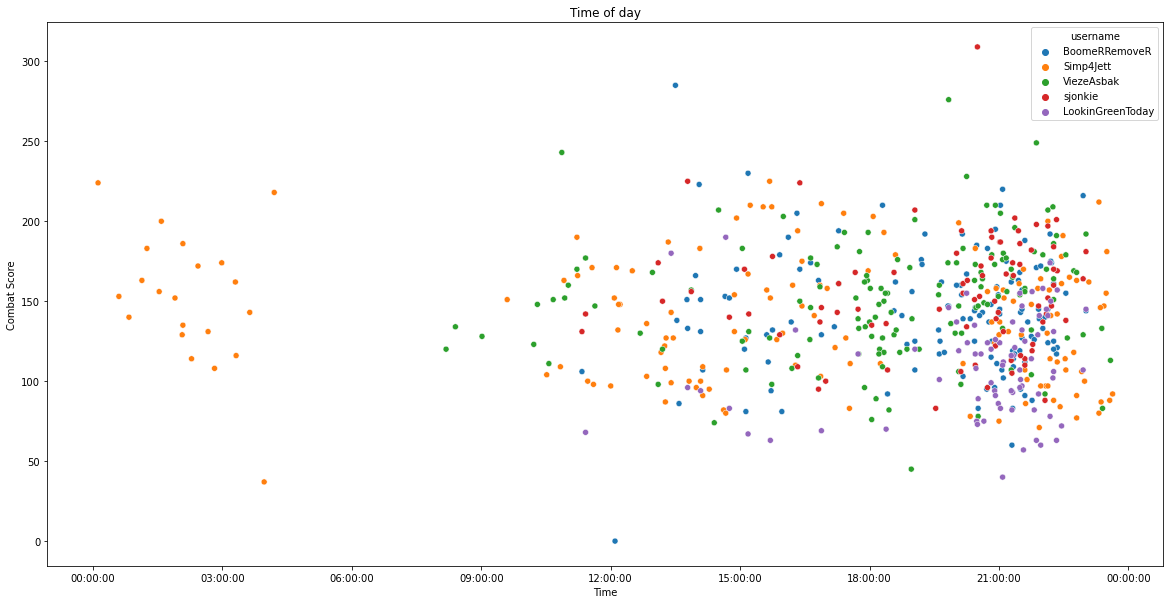

In [531]:
ax = sns.scatterplot(data=df, x='time', y='combat_score_total', hue='username')
ax.set_title('Time of day')
ax.set_xlabel('Time')
ax.set_ylabel('Combat Score')
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M:%S'))
plt.rcParams["figure.figsize"] = (20,10)
plt.show()


In [532]:
# calculate average combat score per username
def get_avg_combat_score(df, username):
    return df[df["username"] == username]["combat_score_total"].mean()

# loop over every username so we can calculate the average combat score
for username in df["username"].unique():
    print("{} avg combat score: {}".format(username, get_avg_combat_score(df, username)))
    # print(username, get_avg_combat_score(df, username))


BoomeRRemoveR avg combat score: 142.53543307086613
Simp4Jett avg combat score: 139.25
ViezeAsbak avg combat score: 149.93617021276594
sjonkie avg combat score: 154.63855421686748
LookinGreenToday avg combat score: 110.01298701298701


Now that we know the average combat score per player, let's see what their most played role is so we can establish a baseline.

In [533]:
# see which class every username uses the most
def get_most_used_class(df, username):
    return df[df["username"] == username]["class"].mode()[0]

# see which class every username uses the most
for username in df["username"].unique():
    print("{} most used class: {}".format(username, get_most_used_class(df, username)))
    # print(username, get_most_used_class(df, username))



BoomeRRemoveR most used class: Sentinel
Simp4Jett most used class: Duelist
ViezeAsbak most used class: Duelist
sjonkie most used class: Controller
LookinGreenToday most used class: Sentinel


In [534]:
# get indication of performance per game per class 


In [535]:
# fig, ax1 = plt.subplots(1, 1, figsize = (20, 10))
# ax1.plot(df['time'], df['combat_score_total'], '.', label = 'Combat Score')
# # x axis 24 hour format
# ax1.set_xticks(np.arange(0, 24, 1))
# ax1.set_xticklabels(np.arange(0, 24, 1))
# # ax1.xaxis.set_major_locator(md.HourLocator(interval = 1))
# # hue = username

# ax1.set_xlabel('Time (24 hour format)')
# ax1.set_ylabel('Combat Score')
# ax1.legend()

# fig.autofmt_xdate(rotation = 0)

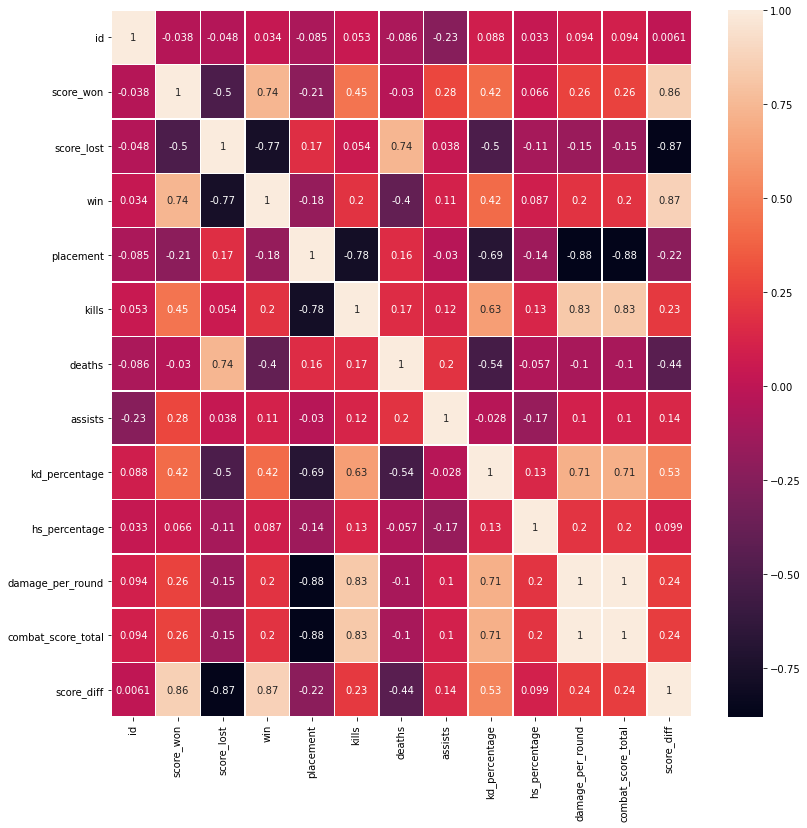

In [536]:
correlation_mat = df.corr()
fig, ax = plt.subplots(figsize=(13,13))
sns.heatmap(correlation_mat, annot = True, linewidths=.5, ax=ax)
plt.show()

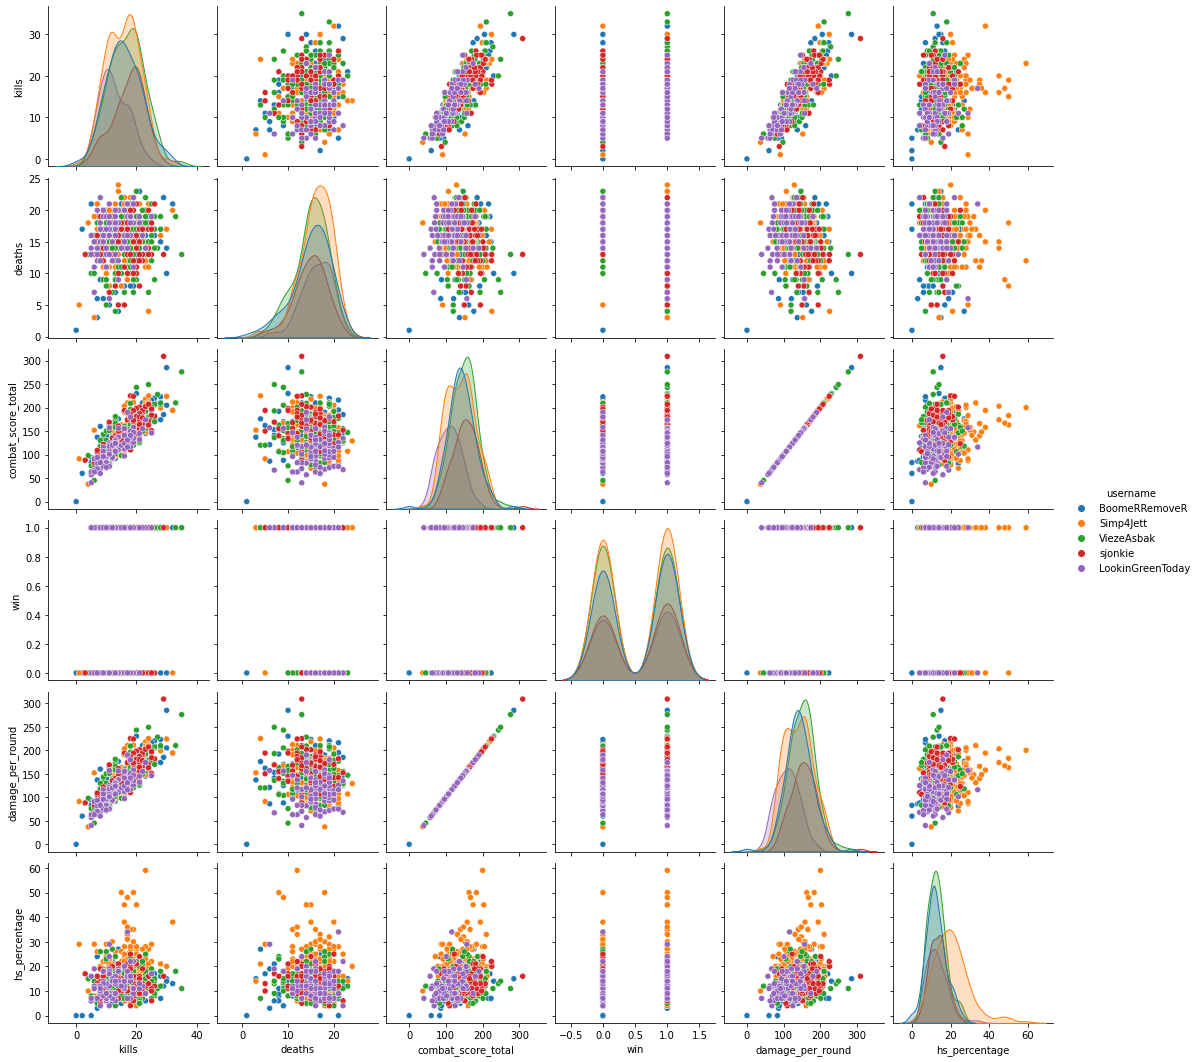

In [537]:
sns.pairplot(data = df[['kills', 'deaths', 'combat_score_total', 'win', 'damage_per_round', 'agent', 'map', 'hs_percentage', 'username']], hue = 'username')

In [538]:
# x = df[['hs_percentage']] 
# y = df['combat_score_total']
# lm = LinearRegression() 
# lm.fit(x, y)

# b0 = lm.intercept_ #gets the intercept
# b1 = lm.coef_[0] #lm.coef_ gets a list of coefficients (excluding the intercept). [0] gets the actual number from the list

# print(f"The regression line is equal to y = {b0:.3f} + {b1:.3f}X") #.0f formats to 3 decimals.

In [539]:
# sns.lmplot(x='hs_percentage', y='combat_score_total', data=df)
# plt.title('')
# plt.xlabel("Headshot Percentage")
# plt.ylabel("Combat Score Total")
# plt.show()

In [540]:
# sns.lmplot(
#     x='kills',
#     y='combat_score_total',
#     hue="username",
#     palette="Set1",
#     row="map",
#     data=df
# )
# plt.title('')
# plt.xlabel("kills")
# plt.ylabel("combat score total")
# plt.show()

# Predictive Model

### Random Forest

In [541]:
# X = df[['kills', 'deaths', 'assists', 'damage_per_round', 'combat_score_total', 'score_diff', 'hs_percentage', 'kd_percentage']] #This gets all the columns from Time to Amount
# y = df['map']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [542]:
# rf = RandomForestClassifier(n_estimators=100) #RF is a random algorithm, so to get the same results we need to use random_state
# rf = rf.fit(X_train, y_train)

In [543]:
# rf.score(X_test,y_test)

In [544]:
# rf.predict([[10, 10, 10, 100, 200, 2, 15, 1.0]])

In [545]:
# clf=RandomForestClassifier(n_estimators=100)
# clf.fit(X_train,y_train)

In [546]:
# feature_imp = pd.Series(clf.feature_importances_, index=clf.feature_names_in_).sort_values(ascending=False)
# feature_imp

In [547]:
# %matplotlib inline
# # Creating a bar plot
# sns.barplot(x=feature_imp, y=feature_imp.index)
# # Add labels to your graph
# plt.xlabel('Feature Importance Score')
# plt.ylabel('Features')
# plt.title("Visualizing Important Features")
# plt.legend()
# plt.show()

### K-Means

In [548]:
# sns.scatterplot(x=df["hs_percentage"], y=df["combat_score_total"], style=df["username"])

In [549]:
# km = KMeans(n_clusters=3) #create a new k-means model with 3 clusters
# X = df[['hs_percentage','damage_per_round', 'combat_score_total', 'kills']] #get the X variables from the dataframe
# km = km.fit(X) #calculate the cluster centers
# df['cluster'] = km.predict(X) #predict the clusters of each observation and store in the dataframe
# df.head()

# sns.scatterplot(x=df["combat_score_total"], y=df["hs_percentage"], style=df["username"], hue=df["cluster"])
